# Machine Learning Project -- Red Wine Quality Dataset

### Team member: Danling Ma, Yunqiu(Julie) Li, Xuyuan Zhang, Xuanbo Mao

## Description of Data

* The Red Wine Dataset contains 12 attributes and 1599 different varieties. 
* All wines evaluated are produced in a particular area of Portugal. 
* Data are collected on 12 different properties of the wines one of which is quality, based on sensory data, and the rest are on chemical properties of the wines including density, acidity, alcohol content etc. 
* All chemical properties of wines are continuous variables. 
* Quality is an ordinal variable with possible ranking from 1 (worst) to 10 (best). 
* Each variety of wine is tasted by three independent tasters and the final rank assigned is the median rank given by the tasters.

* Predictors in our analysis:  11 typles of Wine chemical composition.
* Computed output in our analysis: estimated wine quality.

## Load tools

In [7]:
#Basic
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import  seaborn as sns

#tools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# cross validation machinery
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

## Load and process data

Data shape: (1599, 12)


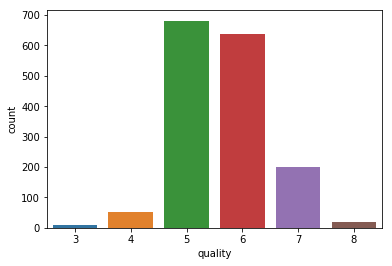

In [8]:
Redwine = pd.read_csv("winequality-red.csv")
sns.countplot(Redwine['quality'])
# check size of dataset
print("Data shape: {}".format(Redwine.shape))
# assign value of 11 physiochemical as X
X = Redwine.values[:,0:11].copy()
# assign value of wine quality as y
y = Redwine.quality.values
# display 11 physiochemical
list(Redwine)
# get a sense of how wine quality distributed in dataset
sns.countplot(Redwine['quality'])

### Set up a binary classifier

In [9]:
#Set an arbitrary cutoff for good wine quality at 5 or higher
ybin = y > 5
print(np.mean(ybin))
Redwine['goodquality'] = ybin

0.5347091932457786


In [10]:
# display dataframe in nice table just to see
Redwine.head()

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,alcohol,quality,goodquality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,True
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,False


### Compare ridge and lasso on some simulated data with a large number of forecasters (right hand side) variables. Run monte-carlos to compare the two. Are there differences? Can you make any statements about which is preferred?

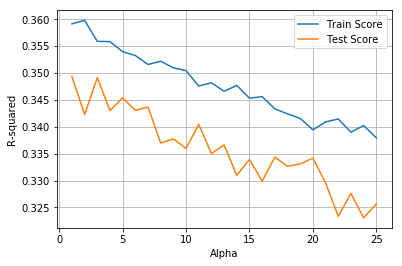

In [5]:
# Ridge Regression
nmc = 100
testScoreList = []
trainScoreList = []
testScore = np.zeros(nmc)
trainScore = np.zeros(nmc)
alpha_range = range(1,26)

for i in alpha_range:
    ridge = Ridge(alpha=i)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
        ridge.fit(X_train, y_train)
        testScore[i]= ridge.score(X_test,y_test)
        trainScore[i]=ridge.score(X_train,y_train)
    trainScoreList.append(np.mean(trainScore))
    testScoreList.append(np.mean(testScore))
plt.plot(alpha_range,trainScoreList,label = 'Train Score')
plt.plot(alpha_range,testScoreList,label = 'Test Score')
plt.xlabel("Alpha")
plt.ylabel("R-squared")
plt.grid()
plt.legend()

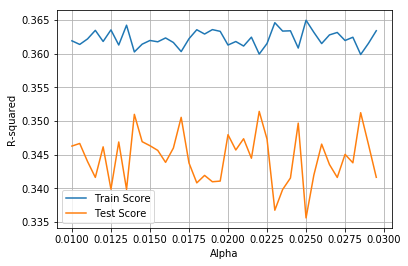

In [6]:
# lasso regression
nmc = 100
testScoreList = []
trainScoreList = []
testScore = np.zeros(nmc)
trainScore = np.zeros(nmc)
alpha_range = np.arange(0.01,0.03,0.0005)
for i in alpha_range:
    ridge = Ridge(alpha=i)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
        ridge.fit(X_train, y_train)
        testScore[i]= ridge.score(X_test,y_test)
        trainScore[i]=ridge.score(X_train,y_train)
    trainScoreList.append(np.mean(trainScore))
    testScoreList.append(np.mean(testScore))
plt.plot(alpha_range,trainScoreList,label = 'Train Score')
plt.plot(alpha_range,testScoreList,label = 'Test Score')
plt.xlabel("Alpha")
plt.ylabel("R-squared")
plt.grid()
plt.legend()

In ridge regression, the R-square keeps decreasing when we increase the penalty. However, the increase of penalty does not have a significant effect on R-square in lasso regression. The R-square drops a little when alpha increases, but when alpha reaches a certain level, R-square rebounds and starts the circle again. We think this is because the lasso model penalizes the coefficient to zero and when a variable is omitted, the R-square would bounce back.  We recommend the lasso model because in this case, some x variables may not have a direct influence on wine quality and these variables could be omitted. Also, compared with ridge model, lasso model almost always has a better fit for test data when penalty varies.

### Try finding a set of neural networks rather than a single one, but estimating with different random seeds. Build your model as an average of the group.

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

random_seeds = [0, 5, 10]
X_train, X_test, y_train, y_test = train_test_split(X, ybin, random_state=0)
mlp1 = MLPClassifier(random_state=0)
mlp2 = MLPClassifier(random_state=5)
mlp3 = MLPClassifier(random_state=10)
# use voting clasifier to build model as an average of 3 mpl classifier with different random seeds
avg_model = VotingClassifier(estimators=[('model1', mlp1), ('model2', mlp2), ('model3', mlp3)], voting='soft', weights=[1, 1, 1])
avg_model = avg_model.fit(X_train, y_train)

print("Accuracy on training set: {:.2f}".format(avg_model.score(X_train, y_train)))
print("Accuracy on test set: {:.2f}".format(avg_model.score(X_test, y_test)))

Accuracy on training set: 0.70
Accuracy on test set: 0.71


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


We can tell from the above result that the overall fitness on training and testing data using MLPClassifier improve significanly compared with the results generated from Ridge and Lasso regresssion. Therefore, the neural network model is more preferable.

### Explore neural network complexity by adding extra width and depth. Plot test sample performance both for increasing width, and increasing depth. Use any of the basic monte-carlos we used in class, or build your own.

In [12]:
neural_network_sizes = [(1,), (1,1), (1,1,1), (10,), (10,10), (10,10,10), (100,), (100,100), (100,100,100)]

for size in neural_network_sizes:
    nmc = 100
    train_scores = np.zeros(nmc)
    test_scores  = np.zeros(nmc)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X, ybin, random_state=0)
        mlp = MLPClassifier(max_iter=1000,hidden_layer_sizes=size, random_state=42)
        mlp.fit(X_train, y_train)
        train_scores[i] = mlp.score(X_train, y_train)
        test_scores[i] = mlp.score(X_test, y_test)

    print("For neural network size: " + str(size))
    print("Accuracy on training set: {:.2f}".format(np.mean(train_scores)))
    print("Accuracy on test set: {:.2f}".format(np.mean(test_scores)))


For neural network size: (1,)
Accuracy on training set: 0.47
Accuracy on test set: 0.46
For neural network size: (1, 1)
Accuracy on training set: 0.47
Accuracy on test set: 0.46
For neural network size: (1, 1, 1)
Accuracy on training set: 0.53
Accuracy on test set: 0.54
For neural network size: (10,)
Accuracy on training set: 0.70
Accuracy on test set: 0.71
For neural network size: (10, 10)
Accuracy on training set: 0.71
Accuracy on test set: 0.73
For neural network size: (10, 10, 10)
Accuracy on training set: 0.65
Accuracy on test set: 0.62
For neural network size: (100,)
Accuracy on training set: 0.69
Accuracy on test set: 0.68
For neural network size: (100, 100)
Accuracy on training set: 0.69
Accuracy on test set: 0.66
For neural network size: (100, 100, 100)
Accuracy on training set: 0.73
Accuracy on test set: 0.69


When width = 1, as we increase the depth of neural network from 1 to 10 and then 100, the accuracy for test data increase and then decrease, which suggests that a model with depth of 100 would be too complex and a model with depth of 10 would probably be the ballpark we should aim for. As we increase the width of neural network to 3, we can notice that the fitness for test data starts to decrease. Based on above result, a neural network model with depth of 10 and width of 10 would be the most preferable.

### Is it possible to overfit your data even when using careful random train/test splits? In other words, would you recommend a special hold out sample be reserved for final model testing?

Yes, we can hold out more subset of the data to test the model further. Because when we build up models, there is always a need to validate the stability of the machine learning model. We need an assurance that the model got most of the patterns from the data correct and not picked up too much on the noise. So when building a machine learning model using some data, we often split our data into training and validation/test sets. The training set is used to train the model, and the validation/test set is used to validate it on data it has never seen before. Practically, we can do 3, 5, 10 or any K-fold of splits. The reason why we need more subset of the data to test the model is that there might be a possibility that both our training data and validation set catch up the data that has similar performance on the model, which causes the score of validation set are close to the score of training set. This may lead us to an illusion that our model is not under/overfitting. By having one more set of data(test data) to test the model, we can lower the 'selection bias' so that to lower the possibility that the model is overfitting. This is called 'Cross Validation', a very useful technique for assessing the effectiveness of your model, particularly in cases where we need to deal with overfitting.